# Goal:

In this notebook, we try to predict character level outcomes, following Multi-Layer Perceptor (MLP) (Bengio et al. 2003)

In [363]:
# idea:
    # we can't expand biagram model to let's say three characters: 27 * 27 -> 27 * 27 * 27 (it's just too high)
    # in this situation, we need to do 'embedding' which means shrinking the size of data to something managebale.
    # the idea is that words or characters that are similar will move to similar part of the new embedded space.

In [470]:
%reset -f

import torch
import seaborn as sns

In [471]:
# reading input data

names = open('names.txt', 'r').read().splitlines()
type(names), len(names), names[0:5]

(list, 32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [473]:
# defining constants and hyper-parameters

START_END_CH = '.'
NUM_OF_PREV_CHAR_TO_USE = 3
EMBEDDING_DIM = 3
TRAIN_VALIDATION_TEST_SPLIT = (0.8, 0.1, 0.1)
NUMBER_OF_NEURONS = 300 # how many nodes in the hidden layer?
BATCH_SIZE = 50

In [474]:
# creating a lookup between characters to alphabet index, and vice versa

stoi = {ch: (i+1) for i, ch in enumerate(sorted(set(''.join(names))))}
stoi[START_END_CH] = 0
itos = {i: ch for ch, i in stoi.items()}

print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [475]:
# building X and Y datasets
# train, validation, and test splits

import random
random.seed(42)


def get_X_and_Y(names):
    X, Y = [], []
    for n in names:
        block = [0] * NUM_OF_PREV_CHAR_TO_USE
        for ch in n + '.':
            ix = stoi[ch]
            X.append(block)
            Y.append(ix)
            # print(''.join(itos[i] for i in block), ' --> ', ch)
            block = [*block[1:], ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.shuffle(names)
n1 = int(len(names) * TRAIN_VALIDATION_TEST_SPLIT[0])
n2 = int(len(names) *
         (TRAIN_VALIDATION_TEST_SPLIT[0] + TRAIN_VALIDATION_TEST_SPLIT[1]))

X_TRAIN, Y_TRAIN = get_X_and_Y(names[0:n1])
X_VALID, Y_VALID = get_X_and_Y(names[n1:n2])
X_TEST , Y_TEST = get_X_and_Y(names[n2:])

X_TRAIN.shape, Y_TRAIN.shape, X_VALID.shape, X_VALID.shape, X_TEST.shape, Y_TEST.shape


(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655, 3]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [476]:
g = torch.Generator().manual_seed(2147483647)

# embedding: we want to go from a 27 dimension (all characters) to a low dimension (EMBEDDING_DIM, let's say 2)
# this is effectively a matrix multiplication: (1, 27) x (27, EMBEDDING_DIM) -> (1, EMBEDDING_DIM)
# we can call this embedding matrix C, which is (27, EMBEDDING_DIM) dimension.
# the values are this matrix itself are part of the optimization: we have to find a transformation which leads to the best outcome
# as an example, similar characters (a, u, i, o, e) are expected to be embedded into a closer area, relative to less similar characters.

# Embedding transformer
C = torch.rand(len(stoi), EMBEDDING_DIM, requires_grad=True)


# the first layer weights and bias (very important)
W1 = torch.rand((NUM_OF_PREV_CHAR_TO_USE * EMBEDDING_DIM, NUMBER_OF_NEURONS), requires_grad=True)
B1 = torch.rand((NUMBER_OF_NEURONS), requires_grad=True)

# the second layer weights and bias
W2 = torch.rand((NUMBER_OF_NEURONS, len(stoi)), requires_grad=True) # the output will have 27 probabilities for each character
B2 = torch.rand((len(stoi)), requires_grad=True)

parameters = [C, W1, B1, W2, B2]

# making sure that parameters have grad
for p in parameters:
    p.requires_grad = True

C.shape, W1.shape, B1.shape, W2.shape, B2.shape

(torch.Size([27, 3]),
 torch.Size([9, 300]),
 torch.Size([300]),
 torch.Size([300, 27]),
 torch.Size([27]))

In [477]:
# Example: A is mapped into this pair in a two dimensional space 
C[stoi['a']]

tensor([0.5891, 0.6720, 0.2141], grad_fn=<SelectBackward0>)

In [341]:
# this is just some few tests (ignore)
if False:
    # forward pass
    # Using C, we can map each input X to a embedded space -> C[X]
    emb = C[X]
    h = torch.tanh(emb.view(-1, NUM_OF_PREV_CHAR_TO_USE * EMBEDDING_DIM) @ W1 + B1) # -1 lets pytorch to decide what number it should be
    logits = h @ W2 + B2
    probs = torch.softmax(logits, dim=1)

    # predicted probability assigned to Y
    # probs[range(len(Y)), Y]
    # loss = -probs[range(len(Y)), Y].log().mean() # nll
    loss = torch.nn.functional.cross_entropy(logits, Y) # a much cleaner way to do the last two lines (a lot more efficient)

    X.shape, emb.shape, h.shape, logits.shape, probs.shape, loss

    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

In [371]:
# important topics:
    # 1. batching (using a subset of data for gradient estimation for faster speed): batching will happen in both forward and backward pass!
    # 2. fine-tuning the step sizes: too small leads to very slow optimization, and too large leads to unstable optimization
    # 3. bias-variance tradeoff
    # 4. train, validation, test samples

# batching leads to noise in the direction of gradient, which leads to noisy loss plots.
# when the difference in loss between trainig and validation is low -> bias problem (underfit ), and when high, it's variance problem (overfit)
# when uderfit, one idea is to increase the number of neurons
# increasing batchsize could also lead to a better gradient estination and signal
# the embedding size (2) could also be a limiting factor.

In [478]:
# number of hyper parameters
sum(p.nelement() for p in parameters)

11208

In [479]:
step = []
list_loss = []

for iter in range(100000):
    # minibatch
    batch_idx = torch.randint(0, len(X_TRAIN), (BATCH_SIZE,))

    # forward pass
    emb = C[X_TRAIN[batch_idx]]    
    h = torch.tanh(
        emb.view(-1, NUM_OF_PREV_CHAR_TO_USE * EMBEDDING_DIM) @ W1 + B1)
    logits = h @ W2 + B2    
    loss = torch.nn.functional.cross_entropy(logits, Y_TRAIN[batch_idx])
    list_loss.append(loss.item())
    step.append(iter)

    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if iter < 50000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

sum(list_loss[-100:]) / 100 # last loss achieved in training set

2.142224690914154

<AxesSubplot:>

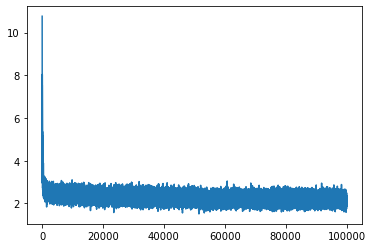

In [480]:
sns.lineplot(x=step, y=list_loss)

In [481]:
# validation sample loss (being used for hyperparameter tuning)
emb = C[X_VALID]
h = torch.tanh(
    emb.view(-1, NUM_OF_PREV_CHAR_TO_USE * EMBEDDING_DIM) @ W1 + B1)
logits = h @ W2 + B2    
loss = torch.nn.functional.cross_entropy(logits, Y_VALID)
loss


tensor(2.1908, grad_fn=<NllLossBackward0>)

In [482]:
# test sample loss
emb = C[X_TEST]
h = torch.tanh(
    emb.view(-1, NUM_OF_PREV_CHAR_TO_USE * EMBEDDING_DIM) @ W1 + B1)
logits = h @ W2 + B2    
loss = torch.nn.functional.cross_entropy(logits, Y_TEST)
loss

tensor(2.1904, grad_fn=<NllLossBackward0>)

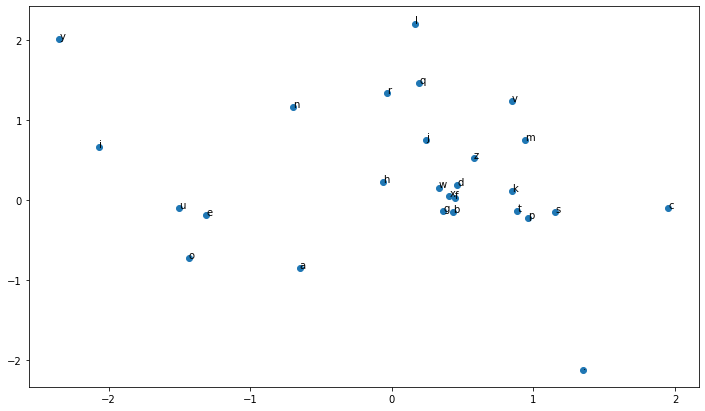

In [469]:
# two dimensional (embedding size = 2)

from matplotlib import pyplot as plt

x_plot = C[:,0].tolist()
y_plot = C[:,1].tolist()
text_plot = list(stoi.keys())

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(x_plot, y_plot)

for i in range(len(x_plot)):
    ax.annotate(itos[i], (x_plot[i], y_plot[i]))

In [501]:
# generating words
g = torch.Generator().manual_seed(2147483647 + 10)


def get_new_names_with_nn(n):
    names = []
    for _ in range(n):
        out = []
        block = [0] * NUM_OF_PREV_CHAR_TO_USE
        while True:
            temp_emb = C[torch.tensor(block)]
            h = torch.tanh(temp_emb.view(-1, NUM_OF_PREV_CHAR_TO_USE * EMBEDDING_DIM) @ W1 + B1)
            logits = h @ W2 + B2
            probs = torch.nn.functional.softmax(logits)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            block = [*block[1:], ix]
            out.append(ix)
            if ix == 0:
                break
        names.append(''.join(itos[i] for i in out[:-1]))
    return names

get_new_names_with_nn(10)

/var/folders/81/p29glqk579jc_zzy2qdvx0g80000gn/T/ipykernel_8398/1338097419.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


['mora',
 'kmyah',
 'seel',
 'ndyn',
 'ala',
 'emman',
 'endraeg',
 'aderedielin',
 'shy',
 'jenleigh']